#**Data Science Assignment - REUNION**
### Background

A person’s creditworthiness is often associated (conversely) with the likelihood they may default on loans. 

We’re giving you anonymized data on about 1000 loan applications, along with a certain set of attributes about the applicant itself, and whether they were considered high risk.

0 = Low credit risk i.e high chance of paying back the loan amount

1 = High credit risk i.e low chance of paying back the loan amount

#Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
sns.set()
%matplotlib inline

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc

le = LabelEncoder()

In [3]:
pd.set_option('max_columns',27)

# Load the dataset

In [4]:
applicants = pd.read_csv("/content/drive/MyDrive/Internships/applicant.csv")
loans = pd.read_csv("/content/drive/MyDrive/Internships/loan.csv")

In [5]:
dataset = pd.merge(applicants,loans,on='applicant_id')
applicant_ids = dataset.pop('applicant_id')
loan_application_ids = dataset.pop('loan_application_id')
#y = dataset.pop('high_risk_applicant')

In [6]:
dataset.shape

(1000, 25)

# Visualize the distribution of features

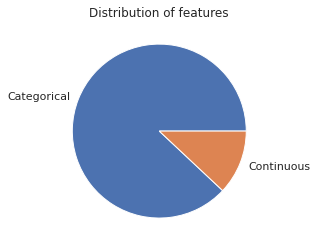

In [7]:
cols = dataset.columns
cat_features = [col for col in cols if dataset[col].nunique() < 25]
cont_features = [col for col in cols if dataset[col].nunique() >= 25]
text = ["Categorical","Continuous"]
values = [len(cat_features),len(cont_features)]
plt.title("Distribution of features")
plt.pie(values,labels=text)
plt.show()

Since most features are categorical, we only have a few continuous features to analyze

#Brief description of the columns
* applicant_id: **Unique** numeric values in order to identify a particular row (can be used as primary key)
* Primary_applicant_age_in_years: Age of the primary applicant
* Number_of_dependents: A measure of how valuable the loan is for a given individual
* Years_at_current_residence: Number of years at current residence
* Employment_status: Classified into four types ->
(skilled employee / official)	or
(unskilled - resident) or
(management / self-employed / highly qualified employee / officer) or (unemployed / unskilled - non-resident)
* Has_been_employed_for_at_least: Minimum number of years the applicant was employed. The missing rows (62) can be filled with zero which would be most appropriate.
* Has_been_employed_for_at_most: Maximum number of years the applicant was employed. The missing rows (253) can be filled with the minimum years the applicant was employed which would be most appropriate.
* Telephone: Information about telephones registered under the applicant's name. Since more than 50% of the rows (596) are missing, these rows can be filled with zeros since we don't have more details.
* Foreign_worker: Does the applicant work in a foreign country
* Savings_account_balance: Four classes indicating the savings account balance of the applicant (Low, Medium, High, Very high). Missing rows have to be dealt with (which will be done later on)
* Balance_in_existing_bank_account: Existing bank balance. Both these columns have more than 45% of the rows missing



In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 25 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   Primary_applicant_age_in_years                            1000 non-null   int64 
 1   Gender                                                    1000 non-null   object
 2   Marital_status                                            1000 non-null   object
 3   Number_of_dependents                                      1000 non-null   int64 
 4   Housing                                                   1000 non-null   object
 5   Years_at_current_residence                                1000 non-null   int64 
 6   Employment_status                                         1000 non-null   object
 7   Has_been_employed_for_at_least                            938 non-null    object
 8   Has_been_employed_for_at_most

# Key points to be noted from the description of the dataframe
* Most of the applicants fall in the age band 19-42
* Number of dependents is 1 for most applicants
* Years at current residence is equally distirbuted from 1-4 years
* Most applicants are foreign workers
* The loan period is mostly within 24 months
* Most applicants do not have any other coapplicants or gurantor
* The applicants have atleast 1 existing loan at the bank

In [9]:
dataset.describe()

Primary_applicant_age_in_years  Number_of_dependents  \
count                     1000.000000           1000.000000   
mean                        35.546000              1.155000   
std                         11.375469              0.362086   
min                         19.000000              1.000000   
25%                         27.000000              1.000000   
50%                         33.000000              1.000000   
75%                         42.000000              1.000000   
max                         75.000000              2.000000   

       Years_at_current_residence  Foreign_worker  Months_loan_taken_for  \
count                 1000.000000     1000.000000            1000.000000   
mean                     2.845000        0.963000              20.903000   
std                      1.103718        0.188856              12.058814   
min                      1.000000        0.000000               4.000000   
25%                      2.000000        1.000000              12.000000   
50%                      3.000000        1.000000              18.000000   
75%                      4.000000        1.000000              24.000000   
max                      4.000000        1.000000              72.000000   

       Principal_loan_amount  EMI_rate_in_percentage_of_disposable_income  \
count           1.000000e+03                                  1000.000000   
mean            3.271258e+06                                     2.973000   
std             2.822737e+06                                     1.118715   
min             2.500000e+05                                     1.000000   
25%             1.365500e+06                                     2.000000   
50%             2.319500e+06                                     3.000000   
75%             3.972250e+06                                     4.000000   
max             1.842400e+07                                     4.000000   

       Has_coapplicant  Has_guarantor  Number_of_existing_loans_at_this_bank  \
count      1000.000000    1000.000000                            1000.000000   
mean          0.041000       0.052000                               1.407000   
std           0.198389       0.222138                               0.577654   
min           0.000000       0.000000                               1.000000   
25%           0.000000       0.000000                               1.000000   
50%           0.000000       0.000000                               1.000000   
75%           0.000000       0.000000                               2.000000   
max           1.000000       1.000000                               4.000000   

       high_risk_applicant  
count          1000.000000  
mean              0.300000  
std               0.458487  
min               0.000000  
25%               0.000000  
50%               0.000000  
75%               1.000000  
max               1.000000

#Profiling Reports

In [ ]:
from pandas_profiling import ProfileReport
ProfileReport(dataset)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
!pip install https://github.com/ydataai/pandas-profiling/archive/master.zip

     - 17.8 MB 5.3 MB/s 0:00:04
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 2.2/2.2 MB 11.6 MB/s eta 0:00:00
     -------------------------------------- 102.7/102.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ------------------------------------- 663.5/663.5 kB 13.9 MB/s eta 0:00:00
     ------------------------------------- 296.5/296.5 kB 19.1 MB/s eta 0:00:00
     -------------------------------------- 153.3/153.3 kB 8.9 MB/s eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 15.3 MB/s eta 0:00:00
     ---------------------------------------- 4.7/4.7 MB 14.4 MB/s eta 0:00:00
     --------------------------------------- 15.6/15.6 MB 13.4 MB/s eta 0:00:00
     --------------------------------------- 28.1/28.1 MB 12.1 MB/s eta 0:00:00
     --------------------------------------- 14

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Dhruv\\anaconda3\\Lib\\site-packages\\~umpy\\core\\_multiarray_tests.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [3]:
!pip install sweetviz

     ---------------------------------------- 15.1/15.1 MB 7.0 MB/s eta 0:00:00


In [4]:
import sweetviz
myreport = sweetviz.analyze(applicants)


NameError: name 'applicants' is not defined

In [ ]:
myreport.show_html("applicant.html")

# Data Analysis

In [10]:
features = dataset.copy()

# Dealing with missing values
* Other_EMI_plans: Since more than 80% of the rows are missing this column will be discarded
* Balance_in_existing_bank_account_(lower_limit_of_bucket): The lower limit has to be zero. So missing values can be filled in with zeroes
* Balance_in_existing_bank_account_(upper_limit_of_bucket): The upper limit can be set to the lower limit value for all the missing rows
* Telephone: The missing rows can be filled with Unregistered which will be a seperate class
* Has_been_employed_for_at_least: The missing rows can be filled with zeroes assuming no previous experience
* Has_been_employed_for_at_most: Since this value has to be greater than or equal to the least number of years the applicant was employed, this can be set to Has_been_employed_for_at_least
* Savings_account_balance: This value is filled with Low for all the missing rows with a general assumption 
* Property: The missing rows are filled with car or other
* Purpose: The missing rows are filled with Miscellaneous (only 12 rows)

In [11]:
total = dataset.isnull().sum().sort_values(ascending=False)
percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(30)

Total  Percent
Other_EMI_plans                                       814    0.814
Balance_in_existing_bank_account_(lower_limit_o...    668    0.668
Telephone                                             596    0.596
Balance_in_existing_bank_account_(upper_limit_o...    457    0.457
Has_been_employed_for_at_most                         253    0.253
Savings_account_balance                               183    0.183
Property                                              154    0.154
Has_been_employed_for_at_least                         62    0.062
Purpose                                                12    0.012
Loan_history                                            0    0.000
Number_of_existing_loans_at_this_bank                   0    0.000
Has_guarantor                                           0    0.000
Has_coapplicant                                         0    0.000
EMI_rate_in_percentage_of_disposable_income             0    0.000
Principal_loan_amount                                   0    0.000
Primary_applicant_age_in_years                          0    0.000
Months_loan_taken_for                                   0    0.000
Gender                                                  0    0.000
Foreign_worker                                          0    0.000
Employment_status                                       0    0.000
Years_at_current_residence                              0    0.000
Housing                                                 0    0.000
Number_of_dependents                                    0    0.000
Marital_status                                          0    0.000
high_risk_applicant                                     0    0.000

In [12]:
features['Balance_in_existing_bank_account_(lower_limit_of_bucket)'] = features['Balance_in_existing_bank_account_(lower_limit_of_bucket)'].fillna(features['Balance_in_existing_bank_account_(upper_limit_of_bucket)'])
features['Balance_in_existing_bank_account_(lower_limit_of_bucket)'] = features['Balance_in_existing_bank_account_(lower_limit_of_bucket)'].fillna('0')
features['Balance_in_existing_bank_account_(upper_limit_of_bucket)'] = features['Balance_in_existing_bank_account_(upper_limit_of_bucket)'].fillna(features['Balance_in_existing_bank_account_(lower_limit_of_bucket)'])
features['Telephone'] = features['Telephone'].fillna('Unregistered')
features['Has_been_employed_for_at_most'] = features['Has_been_employed_for_at_most'].fillna(features['Has_been_employed_for_at_least'])
features['Has_been_employed_for_at_least'] = features['Has_been_employed_for_at_least'].fillna(features['Has_been_employed_for_at_most'])
features['Savings_account_balance'] = features['Savings_account_balance'].fillna('Low')
features['Property'] = features['Property'].fillna('car or other')
features['Purpose'] = features['Purpose'].fillna('Miscellaneous')
unw_cols = ['Other_EMI_plans','EMI_rate_in_percentage_of_disposable_income']
for col in unw_cols:
  try:
    cat_features.remove(col)
  except:
    pass
cat_features.remove('high_risk_applicant')
features.drop(unw_cols,axis=1,inplace=True)

In [13]:
total = features.isnull().sum().sort_values(ascending=False)
percent = (features.isnull().sum()/features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(30)

Total  Percent
Primary_applicant_age_in_years                          0      0.0
Balance_in_existing_bank_account_(lower_limit_o...      0      0.0
Loan_history                                            0      0.0
Number_of_existing_loans_at_this_bank                   0      0.0
Has_guarantor                                           0      0.0
Has_coapplicant                                         0      0.0
Property                                                0      0.0
Principal_loan_amount                                   0      0.0
Purpose                                                 0      0.0
Months_loan_taken_for                                   0      0.0
Balance_in_existing_bank_account_(upper_limit_o...      0      0.0
Savings_account_balance                                 0      0.0
Gender                                                  0      0.0
Foreign_worker                                          0      0.0
Telephone                                               0      0.0
Has_been_employed_for_at_most                           0      0.0
Has_been_employed_for_at_least                          0      0.0
Employment_status                                       0      0.0
Years_at_current_residence                              0      0.0
Housing                                                 0      0.0
Number_of_dependents                                    0      0.0
Marital_status                                          0      0.0
high_risk_applicant                                     0      0.0

# Data visualization

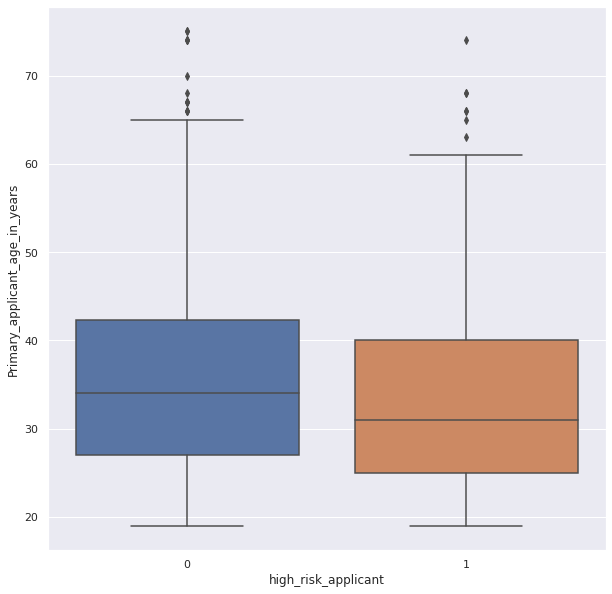

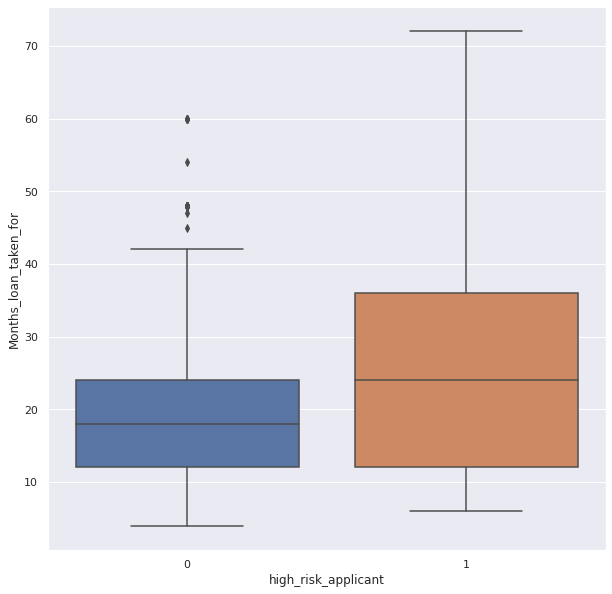

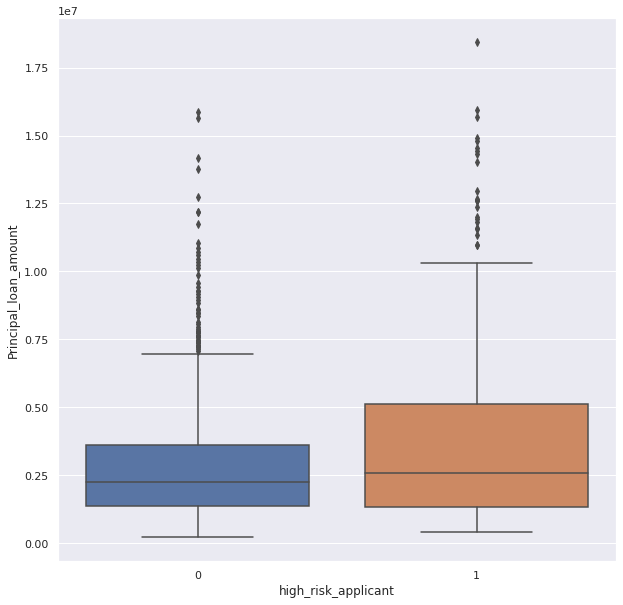

In [14]:
for col in cont_features:
  plt.figure(figsize=(10,10))
  ax = sns.boxplot(x="high_risk_applicant", y=col, data=features)

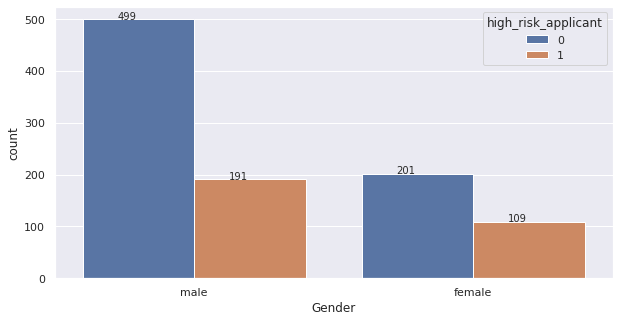

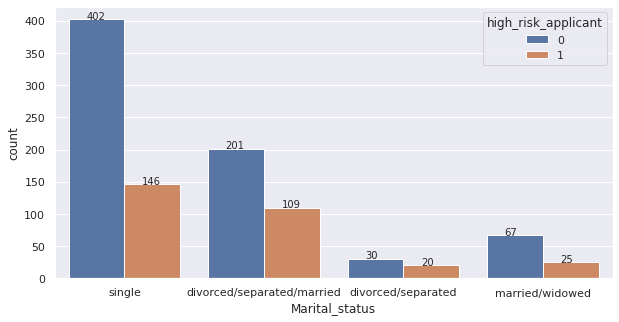

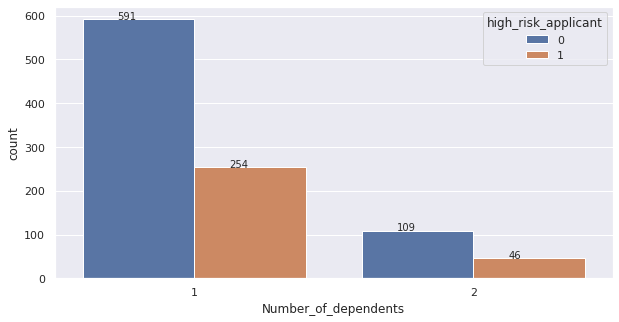

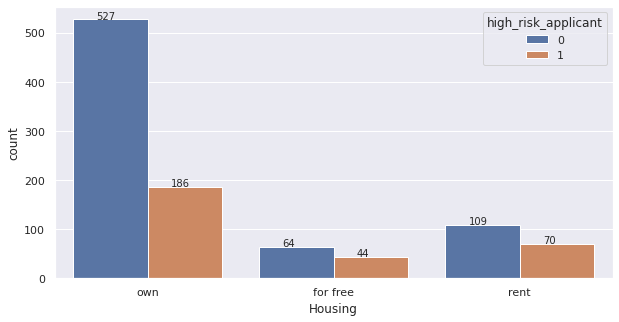

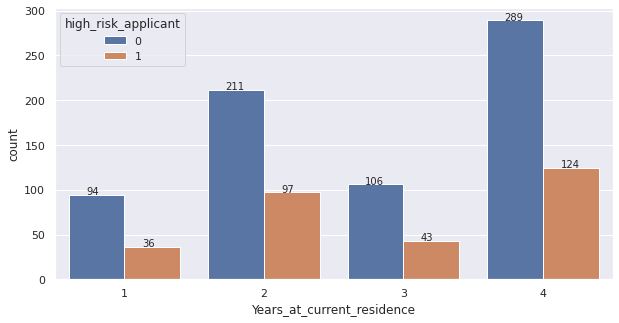

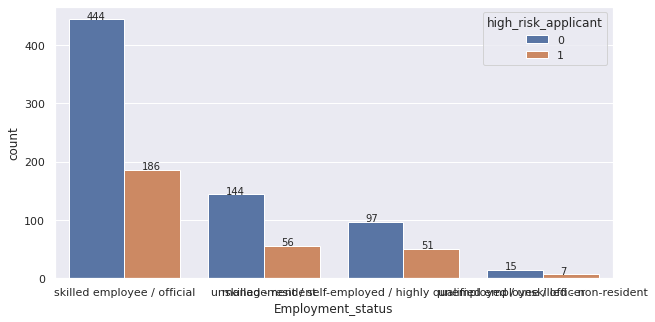

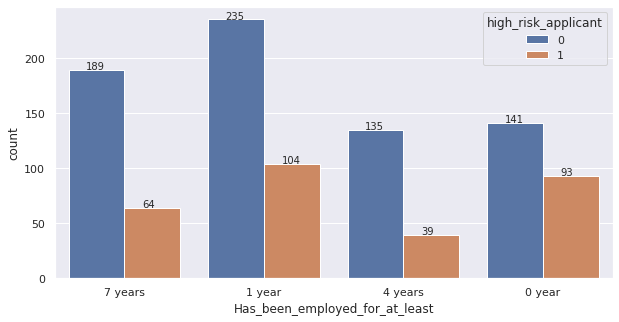

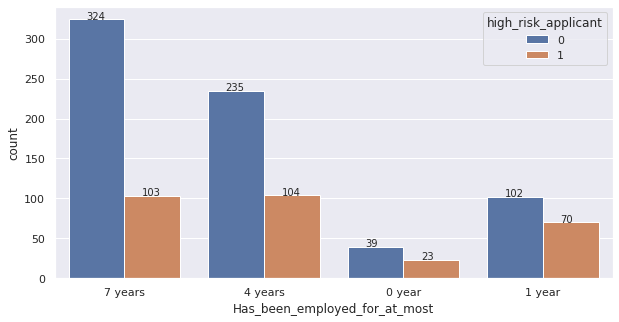

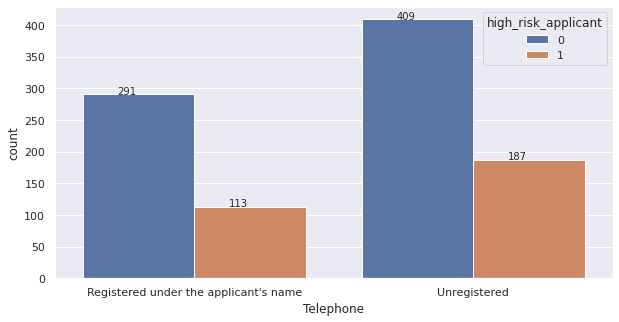

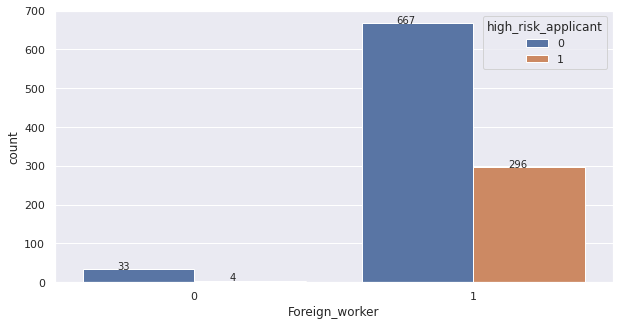

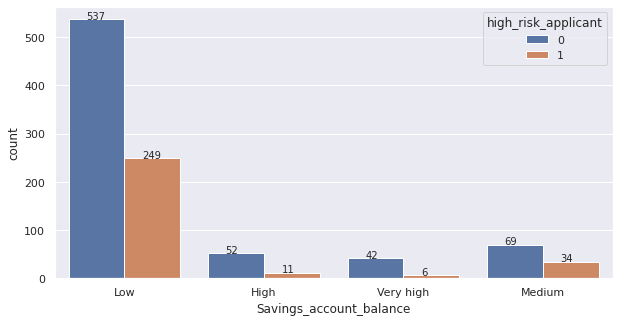

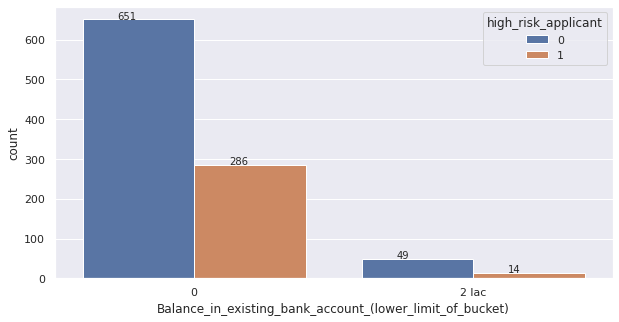

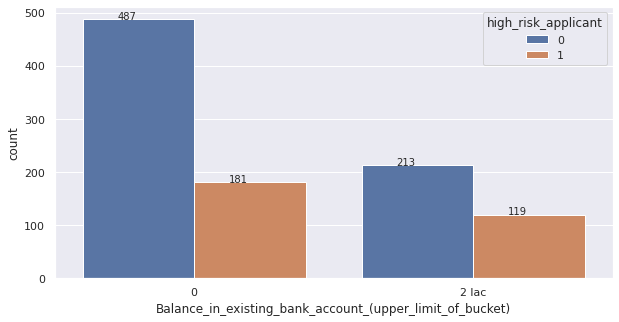

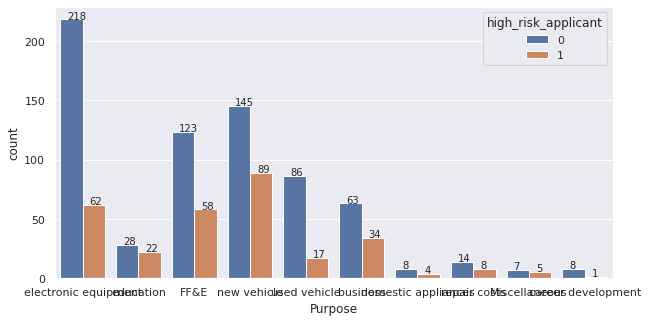

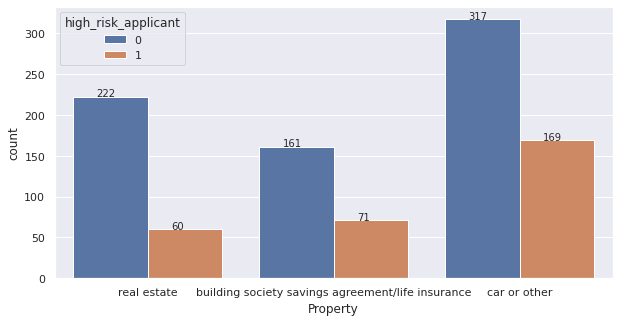

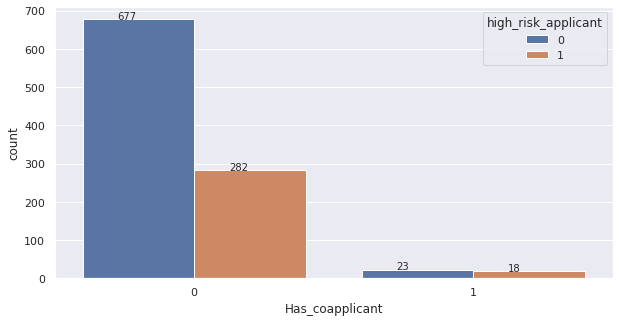

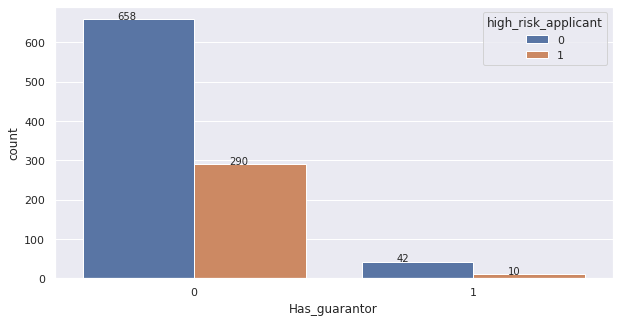

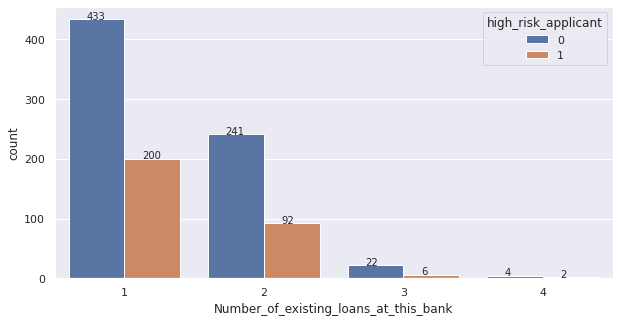

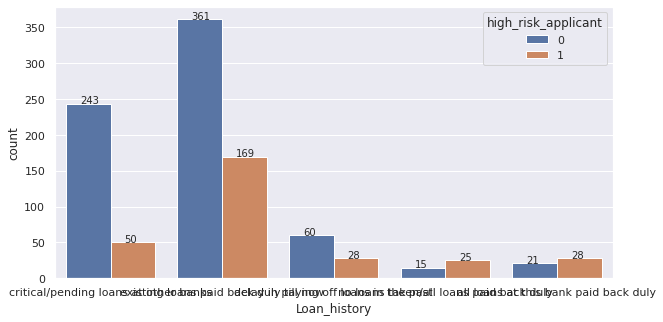

In [15]:
for col in cat_features:
  plt.figure(figsize=(10,5))
  ax = sns.countplot(x = col, hue = 'high_risk_applicant', data = features)
  for p in ax.patches:
   ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.125, p.get_height()+0.5))

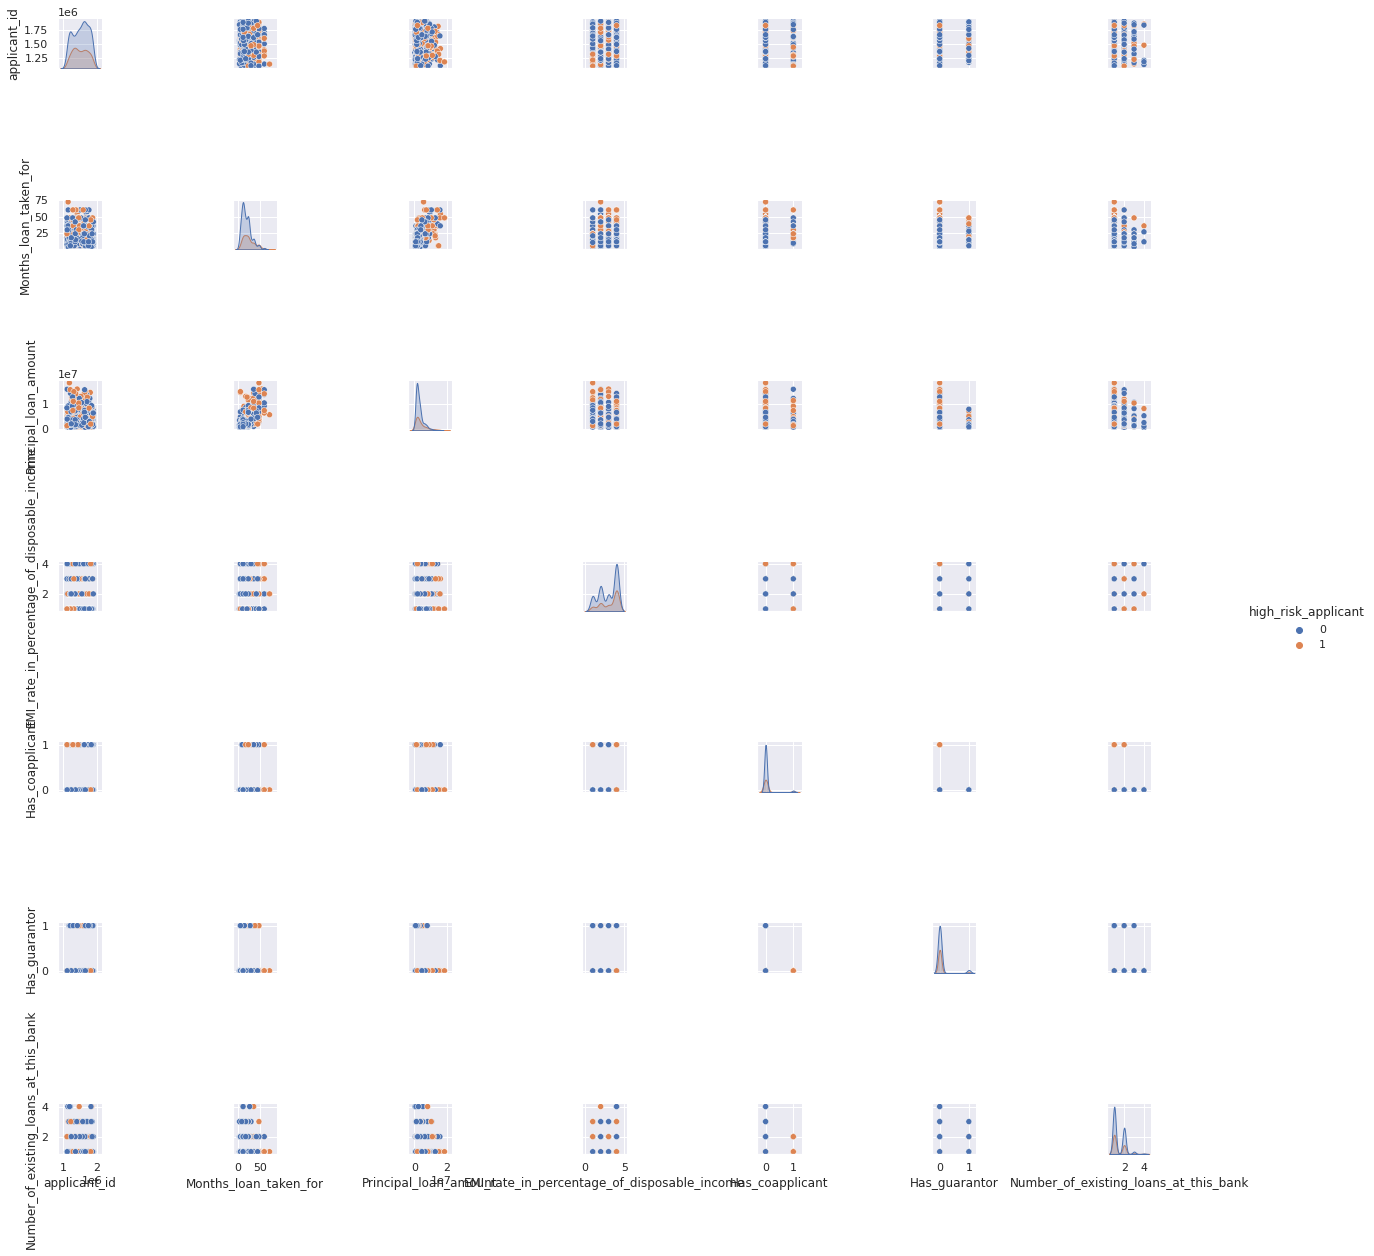

In [16]:
sns.pairplot(data = loans, hue='high_risk_applicant')

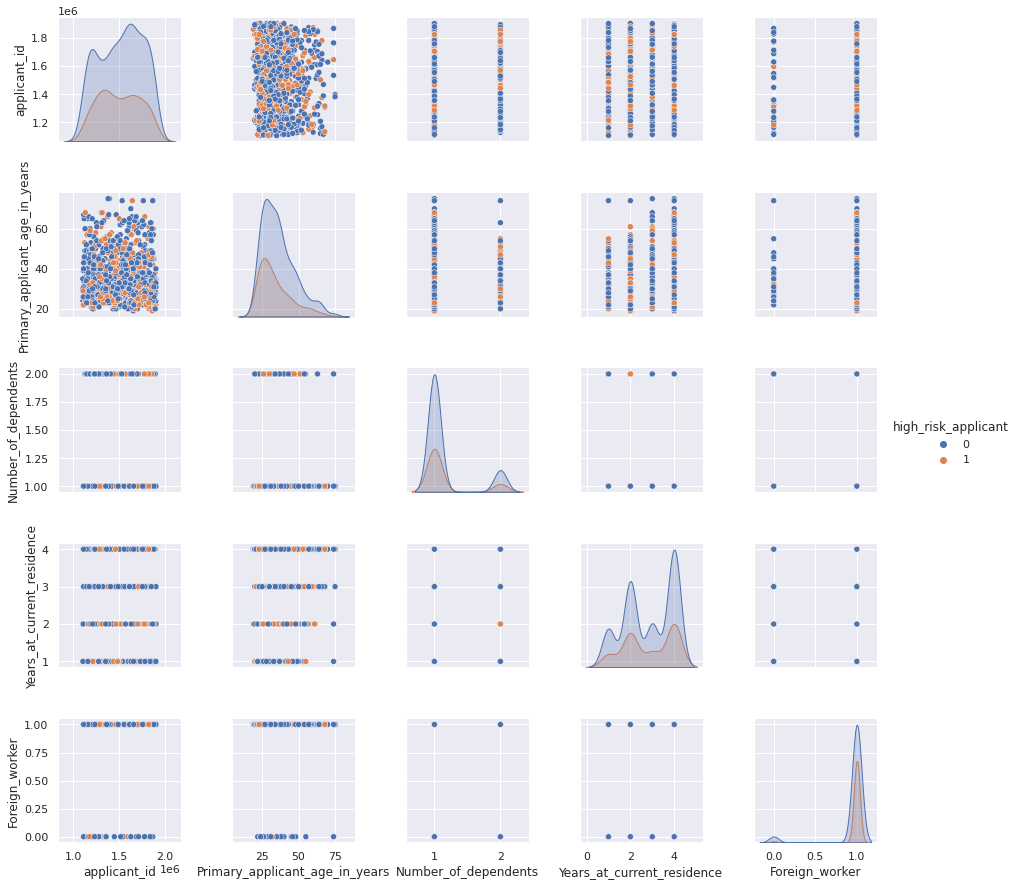

In [17]:
applicants['high_risk_applicant'] = loans['high_risk_applicant']
sns.pairplot(applicants,hue='high_risk_applicant')

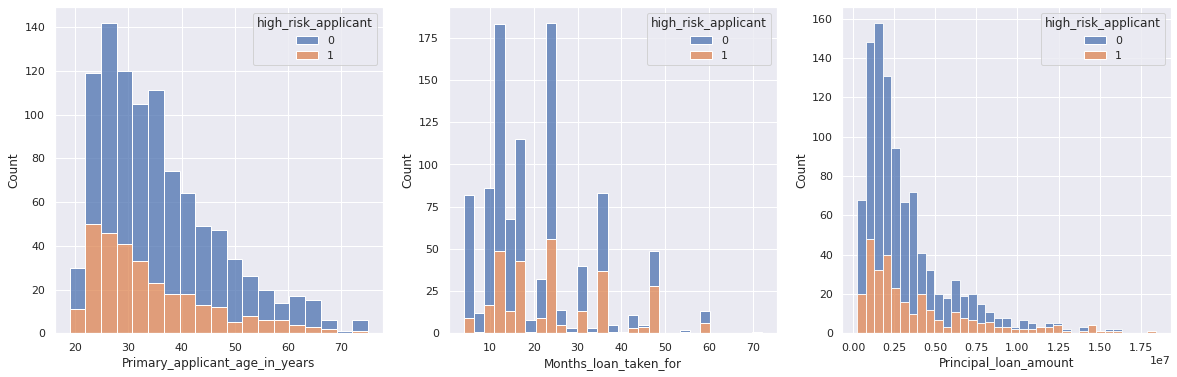

In [19]:
fig,ax = plt.subplots(1,3,figsize=(20,6))
for i,col in enumerate(cont_features):
  sns.histplot(x=col,hue='high_risk_applicant',data=features,ax=ax[i],multiple='stack')
plt.show()

In [20]:
for col in cat_features:
  print(features[[col, 'high_risk_applicant']].groupby([col], as_index=False).mean().sort_values(by='high_risk_applicant', ascending=False))
  print()
  print("-"*20)

   Gender  high_risk_applicant
0  female             0.351613
1    male             0.276812

--------------------
               Marital_status  high_risk_applicant
0          divorced/separated             0.400000
1  divorced/separated/married             0.351613
2             married/widowed             0.271739
3                      single             0.266423

--------------------
   Number_of_dependents  high_risk_applicant
0                     1             0.300592
1                     2             0.296774

--------------------
    Housing  high_risk_applicant
0  for free             0.407407
2      rent             0.391061
1       own             0.260870

--------------------
   Years_at_current_residence  high_risk_applicant
1                           2             0.314935
3                           4             0.300242
2                           3             0.288591
0                           1             0.276923

--------------------
                    

# Correlation matrix

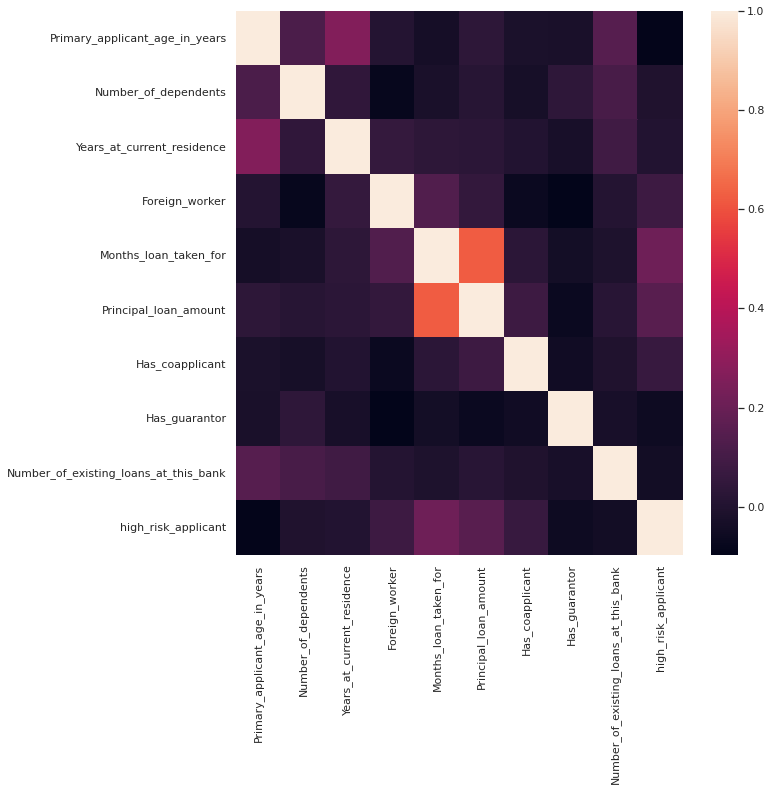

In [21]:
plt.figure(figsize=(10,10))
sns.heatmap(features.corr())

# Feature Engineering and label encoding

In [22]:
filt = ((features['Loan_history'].isin([x for x in range(19,35)])) & (features['Months_loan_taken_for'] >= 25))
features['x1'] = filt*1

In [23]:
features.head()

Primary_applicant_age_in_years  Gender              Marital_status  \
0                              67    male                      single   
1                              22  female  divorced/separated/married   
2                              49    male                      single   
3                              45    male                      single   
4                              53    male                      single   

   Number_of_dependents   Housing  Years_at_current_residence  \
0                     1       own                           4   
1                     1       own                           2   
2                     2       own                           3   
3                     2  for free                           4   
4                     2  for free                           4   

             Employment_status Has_been_employed_for_at_least  \
0  skilled employee / official                        7 years   
1  skilled employee / official                         1 year   
2         unskilled - resident                        4 years   
3  skilled employee / official                        4 years   
4  skilled employee / official                         1 year   

  Has_been_employed_for_at_most                              Telephone  \
0                       7 years  Registered under the applicant's name   
1                       4 years                           Unregistered   
2                       7 years                           Unregistered   
3                       7 years                           Unregistered   
4                       4 years                           Unregistered   

   Foreign_worker Savings_account_balance  \
0               1                     Low   
1               1                     Low   
2               1                     Low   
3               1                     Low   
4               1                     Low   

  Balance_in_existing_bank_account_(lower_limit_of_bucket)  \
0                                                  0         
1                                                  0         
2                                                  0         
3                                                  0         
4                                                  0         

  Balance_in_existing_bank_account_(upper_limit_of_bucket)  \
0                                                  0         
1                                              2 lac         
2                                                  0         
3                                                  0         
4                                                  0         

   Months_loan_taken_for               Purpose  Principal_loan_amount  \
0                      6  electronic equipment                1169000   
1                     48  electronic equipment                5951000   
2                     12             education                2096000   
3                     42                  FF&E                7882000   
4                     24           new vehicle                4870000   

                                            Property  Has_coapplicant  \
0                                        real estate                0   
1                                        real estate                0   
2                                        real estate                0   
3  building society savings agreement/life insurance                0   
4                                       car or other                0   

   Has_guarantor  Number_of_existing_loans_at_this_bank  \
0              0                                      2   
1              0                                      1   
2              0                                      1   
3              1                                      1   
4              0                                      2   

                             Loan_history  high_risk_applicant  x1  
0   critical/pendi

In [24]:
int_features = ['EMI_rate_in_percentage_of_disposable_income','Number_of_dependents','Years_at_current_residence','Foreign_worker','Has_coapplicant','Number_of_existing_loans_at_this_bank','Has_guarantor','high_risk_applicant']
dct = {}
for column in cat_features:
      if column not in int_features and column != 'Other_EMI_plans':
        print(column)
        label = le.fit_transform(features[column])
        dct[column] = le.classes_
        features.drop(column, axis=1, inplace=True)
        features[column] = label

Gender
Marital_status
Housing
Employment_status
Has_been_employed_for_at_least
Has_been_employed_for_at_most
Telephone
Savings_account_balance
Balance_in_existing_bank_account_(lower_limit_of_bucket)
Balance_in_existing_bank_account_(upper_limit_of_bucket)
Purpose
Property
Loan_history


# Synthetic Minority Oversampling

In [26]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

y = features.pop('high_risk_applicant')
# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(features, y)

print('Original dataset shape', len(features))
print('Resampled dataset shape', len(y_smote))

Original dataset shape 1000
Resampled dataset shape 1400


In [27]:
features.head()

Primary_applicant_age_in_years  Number_of_dependents  \
0                              67                     1   
1                              22                     1   
2                              49                     2   
3                              45                     2   
4                              53                     2   

   Years_at_current_residence  Foreign_worker  Months_loan_taken_for  \
0                           4               1                      6   
1                           2               1                     48   
2                           3               1                     12   
3                           4               1                     42   
4                           4               1                     24   

   Principal_loan_amount  Has_coapplicant  Has_guarantor  \
0                1169000                0              0   
1                5951000                0              0   
2                2096000                0              0   
3                7882000                0              1   
4                4870000                0              0   

   Number_of_existing_loans_at_this_bank  x1  Gender  Marital_status  Housing  \
0                                      2   0       1               3        1   
1                                      1   0       0               1        1   
2                                      1   0       1               3        1   
3                                      1   0       1               3        0   
4                                      2   0       1               3        0   

   Employment_status  Has_been_employed_for_at_least  \
0                  1                               3   
1                  1                               1   
2                  3                               2   
3                  1                               2   
4                  1                               1   

   Has_been_employed_for_at_most  Telephone  Savings_account_balance  \
0                              3          0                        1   
1                              2          1                        1   
2                              3          1                        1   
3                              3          1                        1   
4                              2          1                        1   

   Balance_in_existing_bank_account_(lower_limit_of_bucket)  \
0                                                  0          
1                                                  0          
2                                                  0          
3                                                  0          
4                                                  0          

   Balance_in_existing_bank_account_(upper_limit_of_bucket)  Purpose  \
0                                                  0               6   
1                                                  1               6   
2                                                  0               5   
3                                                  0               0   
4                                                  0               7   

   Property  Loan_history  
0         2             1  
1         2             3  
2         2             1  
3         0             3  
4         1             2

# One-hot encoding

In [28]:
onehot_df = pd.get_dummies(x_smote,columns = cat_features)

# Splitting the data into train and test sets

In [88]:
X_train , X_test , y_train , y_test = train_test_split(onehot_df, y_smote, random_state = 12 ,test_size =0.25)

# Implementing AdaBoost

In [89]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [90]:
param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [1, 2]}

In [91]:
DTC = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced",max_depth = None)
ABC = AdaBoostClassifier(base_estimator = DTC)
grid_ABC_clf = GridSearchCV(ABC, param_grid=param_grid, scoring = 'accuracy')

In [92]:
grid_ABC_clf.fit(X_train, y_train)
optimal_ABC_clf = grid_ABC_clf.best_estimator_

In [93]:
# Get the predicted classes
train_class_preds = optimal_ABC_clf.predict(X_train)
test_class_preds = optimal_ABC_clf.predict(X_test)

In [94]:
# Get the accuracy scores
train_accuracy_ABC = accuracy_score(train_class_preds,y_train)
test_accuracy_ABC = accuracy_score(test_class_preds,y_test)

print("The accuracy on train data is ", train_accuracy_ABC)
print("The accuracy on test data is ", test_accuracy_ABC)

The accuracy on train data is  1.0
The accuracy on test data is  0.6942857142857143


[[113  67]
 [ 40 130]]


[Text(0, 0.5, 'Low Risk'), Text(0, 1.5, 'High Risk')]

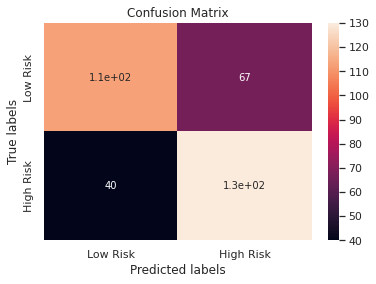

In [95]:
# Calculate F1 score and ROC AUC score
auc_ABC = roc_auc_score(y_test, test_class_preds)
fpr_ABC, tpr_ABC, _ = roc_curve(y_test,  test_class_preds)
f1_score_ABC = f1_score(test_class_preds,y_test)

# Get the confusion matrix for both train and test

labels = ['Low Risk', 'High Risk']
cm = confusion_matrix(y_test, test_class_preds)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

# Implementing Logistic Regression

In [96]:
param_grid = {'penalty':['l1','l2','none'], 'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

In [97]:
grid_lr_clf = GridSearchCV(LogisticRegression(), param_grid, scoring = 'accuracy', n_jobs = -1, verbose = 3, cv = 3)
grid_lr_clf.fit(X_train, y_train)
optimal_LR_clf = grid_lr_clf.best_estimator_

Fitting 3 folds for each of 21 candidates, totalling 63 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
21 fits failed out of a total of 63.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solver

In [98]:
# Get the predicted classes
train_class_preds = optimal_LR_clf.predict(X_train)
test_class_preds = optimal_LR_clf.predict(X_test)

In [99]:
# Get the accuracy scores
train_accuracy_LR = accuracy_score(train_class_preds,y_train)
test_accuracy_LR = accuracy_score(test_class_preds,y_test)

print("The accuracy on train data is ", train_accuracy_LR)
print("The accuracy on test data is ", test_accuracy_LR)

The accuracy on train data is  0.5047619047619047
The accuracy on test data is  0.4857142857142857


[[  0 180]
 [  0 170]]


[Text(0, 0.5, 'Low Risk'), Text(0, 1.5, 'High Risk')]

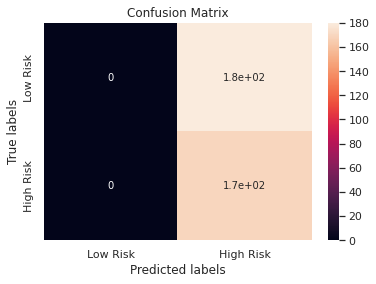

In [100]:
# Calculate F1 score and ROC AUC score
auc_LR = roc_auc_score(y_test, test_class_preds)
fpr_LR, tpr_LR, _ = roc_curve(y_test,  test_class_preds)
f1_score_LR = f1_score(test_class_preds,y_test)

# Get the confusion matrix for both train and test

labels = ['Low Risk', 'High Risk']
cm = confusion_matrix(y_test, test_class_preds)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

# Implementing Support Vector Machine

In [101]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100],   
              'kernel': ['rbf']} 

In [102]:
grid_clf = GridSearchCV(SVC(probability=True), param_grid, scoring = 'accuracy', n_jobs = -1, verbose = 3, cv = 3)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'kernel': ['rbf']},
             scoring='accuracy', verbose=3)

In [103]:
optimal_SVC_clf = grid_clf.best_estimator_

In [104]:
# Get the predicted classes
train_class_preds = optimal_SVC_clf.predict(X_train)
test_class_preds = optimal_SVC_clf.predict(X_test)

In [105]:
# Get the accuracy scores
train_accuracy_SVC = accuracy_score(train_class_preds,y_train)
test_accuracy_SVC = accuracy_score(test_class_preds,y_test)

print("The accuracy on train data is ", train_accuracy_SVC)
print("The accuracy on test data is ", test_accuracy_SVC)

The accuracy on train data is  0.5552380952380952
The accuracy on test data is  0.5857142857142857


[[154  26]
 [119  51]]


[Text(0, 0.5, 'Low Risk'), Text(0, 1.5, 'High Risk')]

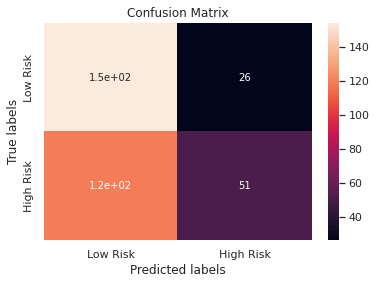

In [106]:
# Calculate F1 score and ROC AUC score
auc_SVC = roc_auc_score(y_test, test_class_preds)
fpr_SVC, tpr_SVC, _ = roc_curve(y_test,  test_class_preds)
f1_score_SVC = f1_score(test_class_preds,y_test)

# Get the confusion matrix for both train and test

labels = ['Low Risk', 'High Risk']
y_pred = optimal_SVC_clf.predict(X_test)
cm = confusion_matrix(y_test, test_class_preds)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

# Implementing Decision Tree

In [107]:
from sklearn.tree import DecisionTreeClassifier  
param_grid = {'max_depth': [20,30,50,100], 'min_samples_split':[0.1,0.2,0.4]}

In [108]:
grid_DTC_clf = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring = 'accuracy', n_jobs = -1, verbose = 3, cv = 3)
grid_DTC_clf.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [20, 30, 50, 100],
                         'min_samples_split': [0.1, 0.2, 0.4]},
             scoring='accuracy', verbose=3)

In [109]:
optimal_DTC_clf = grid_DTC_clf.best_estimator_

In [110]:
# Get the predicted classes
train_class_preds = optimal_DTC_clf.predict(X_train)
test_class_preds = optimal_DTC_clf.predict(X_test)

In [111]:
# Get the accuracy scores
train_accuracy_dtc = accuracy_score(train_class_preds,y_train)
test_accuracy_dtc = accuracy_score(test_class_preds,y_test)

print("The accuracy on train data is ", train_accuracy_dtc)
print("The accuracy on test data is ", test_accuracy_dtc)

The accuracy on train data is  0.7285714285714285
The accuracy on test data is  0.6657142857142857


[[127  53]
 [ 64 106]]


[Text(0, 0.5, 'Low Risk'), Text(0, 1.5, 'High Risk')]

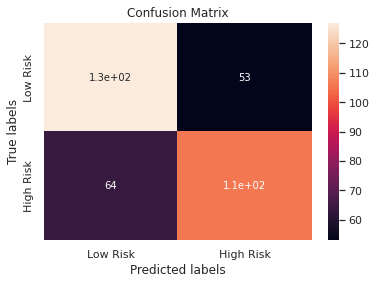

In [112]:
# Calculate F1 score and ROC AUC score
auc_dtc = roc_auc_score(y_test, test_class_preds)
fpr_dtc, tpr_dtc, _ = roc_curve(y_test,  test_class_preds)
f1_score_dtc = f1_score(test_class_preds,y_test)

# Get the confusion matrix for both train and test

labels = ['Low Risk', 'High Risk']
y_pred = optimal_DTC_clf.predict(X_test)
cm = confusion_matrix(y_test, test_class_preds)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

# Implementing XGBoost

In [113]:
# Import lightgbm and xgboost 
import lightgbm as lgb 
import xgboost as xgb

In [114]:
from xgboost import  XGBClassifier

In [115]:
# The data is stored in a DMatrix object 
# label is used to define our outcome variable
dtrain=xgb.DMatrix(X_train,label=y_train)
dtest=xgb.DMatrix(X_test)

In [116]:
# Setting parameters for xgboost
parameters={'max_depth':7, 'eta':1, 'silent':1,'objective':'binary:logistic','eval_metric':'auc','learning_rate':.05}

In [117]:
# Training our model 
num_round=50
from datetime import datetime 
start = datetime.now() 
xg=xgb.train(parameters,dtrain,num_round) 
stop = datetime.now()

In [118]:
#Execution time of the model 
execution_time_xgb = stop-start 
execution_time_xgb

datetime.timedelta(microseconds=203345)

In [119]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='accuracy',n_jobs=-1, cv=3, verbose = 2)
gsearch1.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(colsample_bytree=0.8, max_depth=5,
                                     n_estimators=140, nthread=4, seed=27,
                                     subsample=0.8),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             scoring='accuracy', verbose=2)

In [120]:
optimal_xgb = gsearch1.best_estimator_

In [121]:
# Predictons on train set 
train_class_preds_probs=xg.predict(dtrain) 
# Predictions on test set 
test_class_preds_probs =xg.predict(dtest) 

In [122]:
# Predictons on train set 
train_class_preds_probs = optimal_xgb.predict(X_train) 
# Predictions on test set 
test_class_preds_probs = optimal_xgb.predict(X_test) 

In [123]:
train_class_preds = []
test_class_preds = []
threshold = 0.3
for i in range(0,len(train_class_preds_probs)):
  if train_class_preds_probs[i] >= threshold:
    train_class_preds.append(1)
  else:
    train_class_preds.append(0)

for i in range(0,len(test_class_preds_probs)):
  if test_class_preds_probs[i] >= threshold:
    test_class_preds.append(1)
  else:
    test_class_preds.append(0)

In [124]:
# Get the accuracy scores
train_accuracy_xgb = accuracy_score(train_class_preds,y_train)
test_accuracy_xgb = accuracy_score(test_class_preds,y_test)

print("The accuracy on train data is ", train_accuracy_xgb)
print("The accuracy on test data is ", test_accuracy_xgb)

The accuracy on train data is  0.9990476190476191
The accuracy on test data is  0.8


[[137  43]
 [ 27 143]]


[Text(0, 0.5, 'Low Risk'), Text(0, 1.5, 'High Risk')]

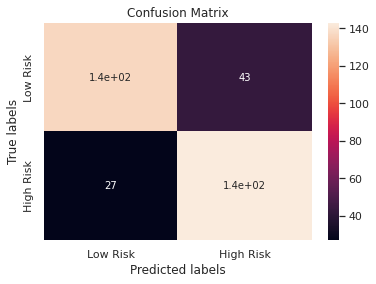

In [125]:
# Calculate F1 score and ROC AUC score
auc_xgb = roc_auc_score(y_test, test_class_preds)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test,  test_class_preds)
f1_score_xgb = f1_score(test_class_preds,y_test)

# Get the confusion matrix for both train and test

labels = ['Low Risk', 'High Risk']
cm = confusion_matrix(y_test, test_class_preds)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

# Implementing K Nearest Neighbours algorithm

In [126]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [127]:
# Get the predicted classes
train_class_preds = neigh.predict(X_train)
test_class_preds = neigh.predict(X_test)

In [128]:
# Get the accuracy scores
train_accuracy_knn = accuracy_score(train_class_preds,y_train)
test_accuracy_knn = accuracy_score(test_class_preds,y_test)

print("The accuracy on train data is ", train_accuracy_knn)
print("The accuracy on test data is ", test_accuracy_knn)

The accuracy on train data is  0.799047619047619
The accuracy on test data is  0.66


[[146  34]
 [ 85  85]]


[Text(0, 0.5, 'Low Risk'), Text(0, 1.5, 'High Risk')]

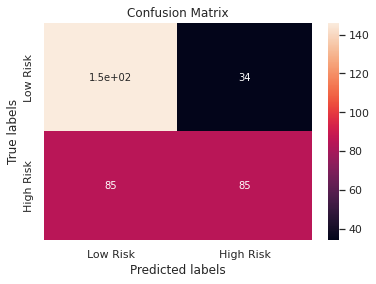

In [129]:
# Calculate F1 score and ROC AUC score
auc_knn = roc_auc_score(y_test, test_class_preds)
fpr_knn, tpr_knn, _ = roc_curve(y_test,  test_class_preds)
f1_score_knn = f1_score(test_class_preds,y_test)

# Get the confusion matrix for both train and test

labels = ['Low Risk', 'High Risk']
cm = confusion_matrix(y_test, test_class_preds)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

# Implementing Naive Bayes algorithm

In [130]:
from sklearn.naive_bayes import BernoulliNB
nb_clf = BernoulliNB()
nb_clf.fit(X_train, y_train)

BernoulliNB()

In [131]:
# Get the predicted classes
train_class_preds = nb_clf.predict(X_train)
test_class_preds = nb_clf.predict(X_test)

In [132]:
# Get the accuracy scores
train_accuracy_nb = accuracy_score(train_class_preds,y_train)
test_accuracy_nb = accuracy_score(test_class_preds,y_test)

print("The accuracy on train data is ", train_accuracy_nb)
print("The accuracy on test data is ", test_accuracy_nb)

The accuracy on train data is  0.7390476190476191
The accuracy on test data is  0.7142857142857143


[[121  59]
 [ 41 129]]


[Text(0, 0.5, 'Low Risk'), Text(0, 1.5, 'High Risk')]

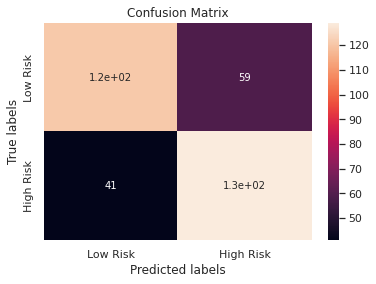

In [133]:
# Calculate F1 score and ROC AUC score
auc_nb = roc_auc_score(y_test, test_class_preds)
fpr_nb, tpr_nb, _ = roc_curve(y_test,  test_class_preds)
f1_score_nb = f1_score(test_class_preds,y_test)

# Get the confusion matrix for both train and test
labels = ['Low Risk', 'High Risk']
cm = confusion_matrix(y_test, test_class_preds)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

# Implementing Gradient Boost

In [134]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1,max_depth=5, random_state=1).fit(X_train, y_train)


In [135]:
# Get the predicted classes
train_class_preds = gb_clf.predict(X_train)
test_class_preds = gb_clf.predict(X_test)

In [136]:
# Get the accuracy scores
train_accuracy_gb = accuracy_score(train_class_preds,y_train)
test_accuracy_gb = accuracy_score(test_class_preds,y_test)

print("The accuracy on train data is ", train_accuracy_gb)
print("The accuracy on test data is ", test_accuracy_gb)

The accuracy on train data is  1.0
The accuracy on test data is  0.7571428571428571


[[139  41]
 [ 44 126]]


[Text(0, 0.5, 'Low Risk'), Text(0, 1.5, 'High Risk')]

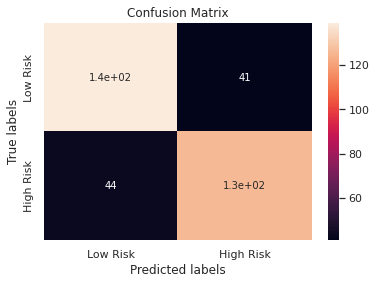

In [137]:
# Calculate F1 score and ROC AUC score
auc_gb = roc_auc_score(y_test, test_class_preds)
fpr_gb, tpr_gb, _ = roc_curve(y_test,  test_class_preds)
f1_score_gb = f1_score(test_class_preds,y_test)

# Get the confusion matrix for both train and test

labels = ['Low Risk', 'High Risk']
cm = confusion_matrix(y_test, test_class_preds)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

# Implementing Random Forest 

In [138]:
from sklearn.ensemble import RandomForestClassifier

In [139]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train,y_train)

RandomForestClassifier()

In [140]:
# Get the predicted classes
train_class_preds = rf_clf.predict(X_train)
test_class_preds = rf_clf.predict(X_test)

In [141]:
# Get the accuracy scores
train_accuracy_rf = accuracy_score(train_class_preds,y_train)
test_accuracy_rf = accuracy_score(test_class_preds,y_test)

print("The accuracy on train data is ", train_accuracy_rf)
print("The accuracy on test data is ", test_accuracy_rf)

The accuracy on train data is  1.0
The accuracy on test data is  0.8057142857142857


[[145  35]
 [ 33 137]]


[Text(0, 0.5, 'Low Risk'), Text(0, 1.5, 'High Risk')]

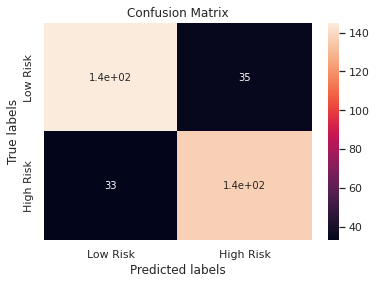

In [142]:
# Calculate F1 score and ROC AUC score
auc_rf = roc_auc_score(y_test, test_class_preds)
fpr_rf, tpr_rf, _ = roc_curve(y_test,  test_class_preds)
f1_score_rf = f1_score(test_class_preds,y_test)

# Get the confusion matrix for both train and test

labels = ['Low Risk', 'High Risk']
cm = confusion_matrix(y_test, test_class_preds)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

# Evaluating the mdoels

In [143]:
classifiers = ['AdaBoost','Logistic Regression','Support Vector Machine','Decision Tree','XGBoost','K Nearest Neighbours','Naive Bayes','Gradient Boost','Random Forest']
models = [optimal_ABC_clf,optimal_LR_clf,optimal_SVC_clf,optimal_DTC_clf,optimal_xgb,neigh,nb_clf,gb_clf,rf_clf]
train_accuracy = [train_accuracy_ABC,train_accuracy_LR,train_accuracy_SVC,train_accuracy_dtc,train_accuracy_xgb,train_accuracy_knn,train_accuracy_nb,train_accuracy_gb,train_accuracy_rf]
test_accuracy = [test_accuracy_ABC,test_accuracy_LR,test_accuracy_SVC,test_accuracy_dtc,test_accuracy_xgb,test_accuracy_knn,test_accuracy_nb,test_accuracy_gb,test_accuracy_rf]
auc_scores = [auc_ABC,auc_LR,auc_SVC,auc_dtc,auc_xgb,auc_knn,auc_nb,auc_gb,auc_rf]
f1_scores = [f1_score_ABC,f1_score_LR,f1_score_SVC,f1_score_dtc,f1_score_xgb,f1_score_knn,f1_score_nb,f1_score_gb,f1_score_rf]
fpr = [fpr_ABC,fpr_LR,fpr_SVC,fpr_dtc,fpr_xgb,fpr_knn,fpr_nb,fpr_gb,fpr_rf]
tpr = [tpr_ABC,tpr_LR,tpr_SVC,tpr_dtc,tpr_xgb,tpr_knn,tpr_nb,tpr_gb,tpr_rf]
results = pd.DataFrame({'Classifier':classifiers, 'Train Accuracy': train_accuracy, 'Test Accuracy': test_accuracy, 'AUC':auc_scores, 'F1 Score': f1_scores})
results['Score'] = round(2 * (results['Train Accuracy'] + results['AUC'] + results['F1 Score']) + 4 * results['Test Accuracy'],2)
results

Classifier  Train Accuracy  Test Accuracy       AUC  F1 Score  \
0                AdaBoost        1.000000       0.694286  0.696242  0.708447   
1     Logistic Regression        0.504762       0.485714  0.500000  0.653846   
2  Support Vector Machine        0.555238       0.585714  0.577778  0.412955   
3           Decision Tree        0.728571       0.665714  0.664542  0.644377   
4                 XGBoost        0.999048       0.800000  0.801144  0.803371   
5    K Nearest Neighbours        0.799048       0.660000  0.655556  0.588235   
6             Naive Bayes        0.739048       0.714286  0.715523  0.720670   
7          Gradient Boost        1.000000       0.757143  0.756699  0.747774   
8           Random Forest        1.000000       0.805714  0.805719  0.801170   

   Score  
0   7.59  
1   5.26  
2   5.43  
3   6.74  
4   8.41  
5   6.73  
6   7.21  
7   8.04  
8   8.44

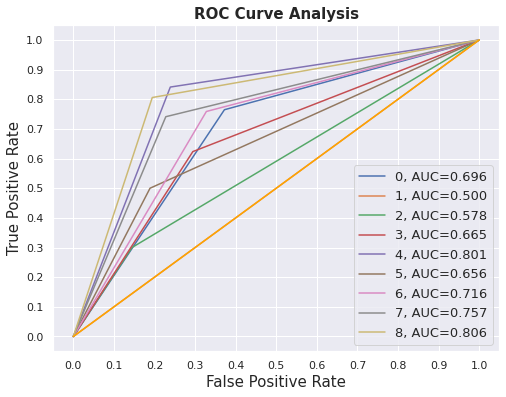

In [144]:
results['TPR'] = tpr
results['FPR'] = fpr
fig = plt.figure(figsize=(8,6))

for i in results.index:
    plt.plot(results.loc[i]['FPR'], 
             results.loc[i]['TPR'], 
             label="{}, AUC={:.3f}".format(i, results.loc[i]['AUC']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='-')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()